<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/dev/Week%2009%20-%20Introduction%20to%20Rockets/LaunchTrajectoryAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Launch Trajectory Analysis
This workbook is being developed to facilitate the analysis of rocket propulsion systems for launch and recovery purposes.

In [8]:
!pip install -q ambiance pint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 17.9 MB/s eta 0:00:00


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import urllib.request, io
from PIL import Image

# Set default font sizes for better visibility in presentations
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
})

%matplotlib inline
%config InlineBackend.figure_format='retina'

from dataclasses import dataclass

from scipy.integrate import solve_ivp
from scipy import constants


from ambiance import Atmosphere

from typing import Dict, Any, List, Union, Tuple

import pandas as pd

from pint import UnitRegistry
ureg = UnitRegistry(); Q_ = ureg.Quantity

In [10]:
# Download and load the Earth texture image from a reliable NASA source
image_url = "https://antwrp.gsfc.nasa.gov/apod/image/0304/bluemarble2k_big.jpg"
try:
  with urllib.request.urlopen(image_url) as url:
    f = io.BytesIO(url.read())
  img = Image.open(f)
  # The image needs to be flipped vertically for correct mapping
  earth_texture = np.array(img.transpose(Image.FLIP_TOP_BOTTOM)) / 255.
except Exception as e:
  print(f"Could not download or process Earth texture: {e}")
  earth_texture = None

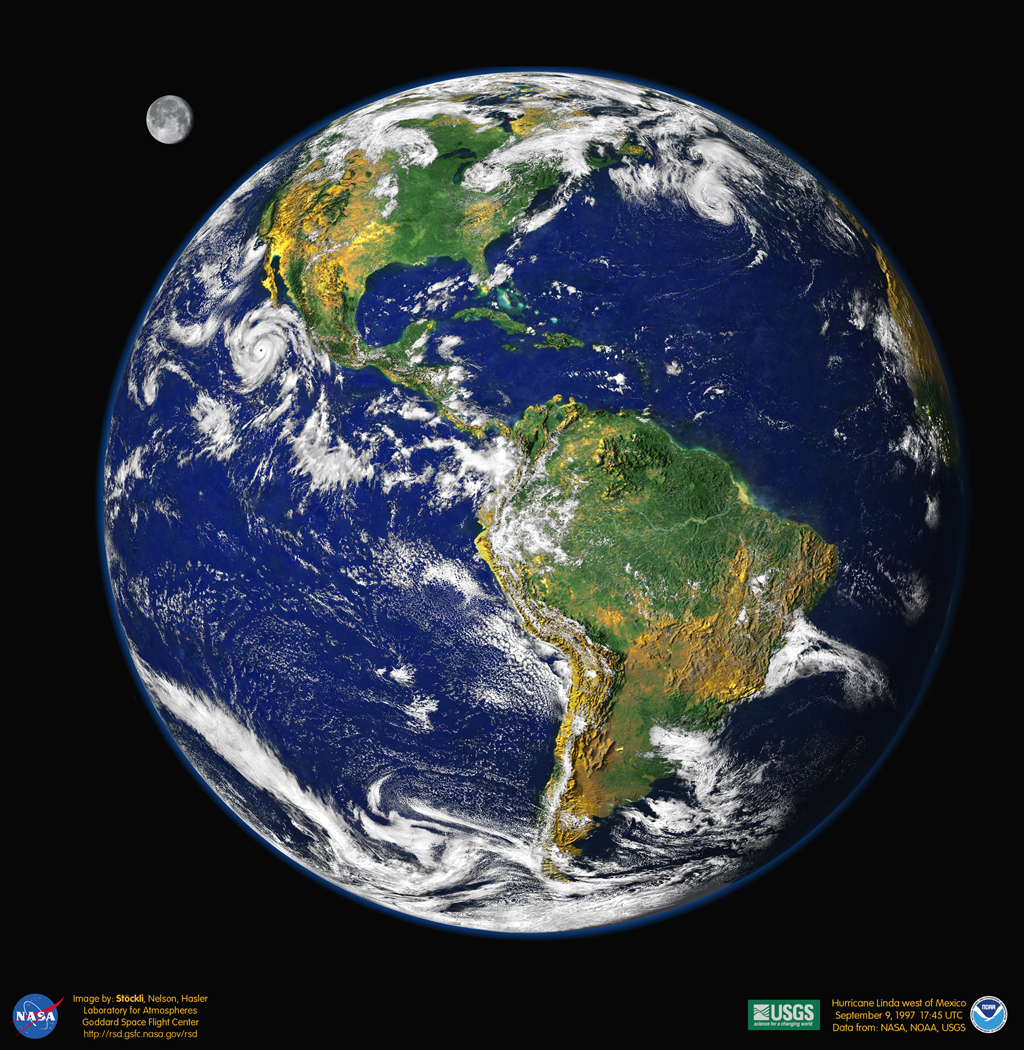

In [96]:
display(img)

In [19]:
# Define dataclasses to facilitate the specification of engine, stage & rocket designs

# --- Engine Specifications ---

@dataclass
class Engine:
  name = "Raptor"
  fuel = "CH4"
  oxidizer = "O2(l)"
  thrust: Q_ = Q_(507e3, "lbf")
  isp: Q_ = Q_(np.nan, "s")

Raptor = Engine()
RaptorVac = Engine(thrust=Q_(568e3, "lbf"), isp=Q_(np.nan, "s"))

# --- Stage Specifications ---

@dataclass
class Stage:
  """**Stage** is a dataclass that contains rocket stage design
  specifications appropriate for a reduced order mission analysis.

  The input parameters are as follows--
    **name** (*str*) -  the stage name,
    **dry_mass** (*Q_*) - the dry mass of the stage,
    **propellant_mass** (*Q_*) - the total propellant mass,
    **diameter** (*Q_*) - the stage diameter,
    **cd** (*Q_*) - the stage drag coefficient
    **engines** (*Tuple[Tuple]*) - A tuple of tuples that specify the number and type of engines employed.

  The default specifications are for the Starship, which is the second stage
  of the SpaceX Starship System."""
  name: str = "Starship - Stage 2"
  dry_mass: Q_ = Q_(np.nan, 'lb')
  propellant_mass: Q_ = Q_(3.3e6, 'lb')
  diameter: Q_ = Q_(9, 'm')
  cd: float = 0.5
  engines: Tuple[Tuple[int, Engine]] = ((6, Raptor), (3, RaptorVac))
  total_mass = dry_mass + propellant_mass

# Example stages
Starship = Stage()
SuperHeavy = Stage(name="Super Heavy",
                   dry_mass=Q_(np.nan, 'kg'),
                   propellant_mass=Q_(7.5e6, "lb"),
                   diameter=Q_(9, 'm'),
                   cd=0.5,
                   engines=((33, Raptor)))


# --- Rocket Specification ---

@dataclass
class RocketDesign:
  name: str = "Starship System"
  stages: Tuple[Stage] = (Starship, SuperHeavy)
  dry_mass = sum(stage.dry_mass for stage in stages)
  propellant_mass = sum(stage.propellant_mass for stage in stages)


In [33]:
class PropulsionStage:
  """
  A class to model a rocket propulsion stage.
  This is the "plug-in" for your concepts.
  """
  def __init__(self, thrust_vac, isp_vac, isp_sl, initial_propellant_mass):
    self.thrust_vac = thrust_vac
    self.isp_vac = isp_vac
    self.isp_sl = isp_sl
    self.initial_propellant_mass = initial_propellant_mass
    self.mdot_vac = self.thrust_vac / (self.isp_vac * constants.g)

  def get_thrust_mdot(self, altitude, current_propellant_mass):
    """
    Calculates thrust and mass flow rate at a given altitude.
    """
    if current_propellant_mass <= 0:
      return 0.0, 0.0

    try:
      atm = Atmosphere(altitude)
      pressure = atm.pressure[0] # Access the scalar value
    except ValueError:
      pressure = 0.0

    pressure_ratio = pressure / constants.atm
    current_isp = self.isp_vac + (self.isp_sl - self.isp_vac) * pressure_ratio

    current_mdot = self.mdot_vac
    current_thrust = current_mdot * current_isp * constants.g

    dt = 0.01
    if current_propellant_mass < (current_mdot * dt):
      current_mdot = current_propellant_mass / dt

    return current_thrust, current_mdot

class Trajectory:
  """
  A class to handle the simulation of a rocket trajectory in a
  3D spherical coordinate system.
  """
  def __init__(self, rocket_params, engine_params):
    # Rocket properties
    self.dry_mass = rocket_params['dry_mass']
    self.propellant_mass = rocket_params['propellant_mass']
    self.initial_mass = self.dry_mass + self.propellant_mass
    self.area = rocket_params['area']
    self.cd = rocket_params['cd']
    self.engine_params = engine_params

    # Earth constants (explicitly defined)
    self.R_EARTH = 6378137.0  # Earth equatorial radius in meters
    self.M_EARTH = 5.9722e24  # Earth mass in kg
    self.MU_EARTH = constants.G * self.M_EARTH
    self.OMEGA_EARTH = 7.2921159e-5 # rad/s

    # Guidance Program Parameters
    self.vertical_ascent_time = 10.0  # s

    # Create the engine instance with the initial propellant mass
    self.engine = PropulsionStage(
        thrust_vac=self.engine_params['thrust_vac'],
        isp_vac=self.engine_params['isp_vac'],
        isp_sl=self.engine_params['isp_sl'],
        initial_propellant_mass=self.propellant_mass # Pass initial propellant mass
    )

    # Create a history variable for the
    self.history = {"t": [],
                    "gravity_force_mag": [],
                    "drag_force_mag": [],
                    "thrust_force_mag": []}

  def _get_gravity_force_r(self, r, mass):
    """Calculates the scalar gravity force (acts only in the -r direction)."""
    return - (self.MU_EARTH * mass) / (r**2)

  def _get_drag_force_components(self, r, vr, vtheta, vphi):
    """Calculates drag force components in r, theta, and phi directions."""
    altitude = r - self.R_EARTH

    try:
      atm = Atmosphere(altitude)
      density = atm.density[0] # Access the scalar value
    except ValueError:
      return 0.0, 0.0, 0.0

    v_mag = np.sqrt(vr**2 + vtheta**2 + vphi**2)
    if v_mag < 1e-6:
      return 0.0, 0.0, 0.0

    drag_mag = 0.5 * density * (v_mag**2) * self.cd * self.area

    # Resolve drag into components opposing velocity
    drag_r = -drag_mag * (vr / v_mag)
    drag_theta = -drag_mag * (vtheta / v_mag)
    drag_phi = -drag_mag * (vphi / v_mag)

    return drag_r, drag_theta, drag_phi

  def _get_thrust_components(self, t, vr, vtheta, vphi, thrust_magnitude):
    """Implements a 3D gravity turn guidance program."""
    if t < self.vertical_ascent_time:
      # Vertical Ascent: Thrust purely in the radial direction
      return thrust_magnitude, 0.0, 0.0
    else:
      # Gravity Turn: Align thrust with the velocity vector (prograde)
      v_mag = np.sqrt(vr**2 + vtheta**2 + vphi**2)
      if v_mag < 1e-6:
        return thrust_magnitude, 0.0, 0.0

      thrust_r = thrust_magnitude * (vr / v_mag)
      thrust_theta = thrust_magnitude * (vtheta / v_mag)
      thrust_phi = thrust_magnitude * (vphi / v_mag)
      return thrust_r, thrust_theta, thrust_phi

  def _derivatives(self, t, state):
    """
    Calculates the derivatives of the state vector for the integrator.
    State vector: [r, theta, phi, vr, vtheta, vphi, mass]
    r: radial distance
    theta: polar angle (co-latitude)
    phi: azimuthal angle (longitude)
    vr, vtheta, vphi: velocity components in r, theta, phi directions
    """
    # 1. Unpack state
    r, theta, phi, vr, vtheta, vphi, current_mass = state

    current_propellant = current_mass - self.dry_mass
    altitude = r - self.R_EARTH

    # 2. Get forces and mass flow rate
    F_gravity_r = self._get_gravity_force_r(r, current_mass)
    F_drag_r, F_drag_theta, F_drag_phi = self._get_drag_force_components(r, vr, vtheta, vphi)

    thrust_mag, mdot = self.engine.get_thrust_mdot(altitude, current_propellant)
    F_thrust_r, F_thrust_theta, F_thrust_phi = self._get_thrust_components(t, vr, vtheta, vphi, thrust_mag)

    # 3. Sum forces in each direction
    F_total_r = F_gravity_r + F_drag_r + F_thrust_r
    F_total_theta = F_drag_theta + F_thrust_theta
    F_total_phi = F_drag_phi + F_thrust_phi

    # 4. Calculate derivatives using equations of motion in spherical coordinates
    dr_dt = vr
    dphi_dt = vphi / r
    # Handle singularity at the poles for dtheta_dt
    dtheta_dt = vtheta / (r * np.sin(phi)) if np.sin(phi) > 1e-8 else 0

    # Fictitious force terms arise from using a non-inertial (rotating) basis
    dvr_dt = (F_total_r / current_mass) + (vphi**2 / r) + (vtheta**2 / r)
    dvphi_dt = (F_total_phi / current_mass) - (vr * vphi / r) + ((vtheta**2 / r) * (np.cos(phi) / np.sin(phi)))
    dvtheta_dt = (F_total_theta / current_mass) - (vr * vtheta / r) - ((vphi * vtheta / r) * (np.cos(phi) / np.sin(phi)))

    dmass_dt = -mdot

    # Update the history
    self.history["t"].append(t)
    self.history["gravity_force_mag"].append(F_gravity_r)
    self.history["drag_force_mag"].append(np.sqrt(F_drag_r**2 + F_drag_theta**2 + F_drag_phi**2))
    self.history["thrust_force_mag"].append(np.sqrt(F_thrust_r**2 + F_thrust_theta**2 + F_thrust_phi**2))

    return [dr_dt, dtheta_dt, dphi_dt, dvr_dt, dvtheta_dt, dvphi_dt, dmass_dt]

  def run_simulation(self, t_span, launch_site_latitude=0):
    """Sets up and runs the trajectory simulation."""
    # --- Initial Conditions (for an eastward launch) ---
    launch_lat_rad = np.deg2rad(launch_site_latitude)

    initial_r = self.R_EARTH
    initial_theta = 0  # Longitude
    initial_phi = np.pi/2 - launch_lat_rad # Co-Latitude (polar angle)

    initial_vr = 0.0
    initial_vtheta = self.OMEGA_EARTH * self.R_EARTH * np.sin(initial_phi)
    initial_vphi = 0.0

    initial_state = [initial_r, initial_theta, initial_phi, initial_vr, initial_vtheta, initial_vphi, self.initial_mass]

    # --- Define Events to stop the simulation ---
    def hit_ground(t, state):
      return state[0] - self.R_EARTH # r - R_EARTH
    hit_ground.terminal = True
    hit_ground.direction = -1

    #def out_of_fuel(t, state):
    #  return state[6] - self.dry_mass
    #out_of_fuel.terminal = True

    print("--- Starting Simulation ---")
    sol = solve_ivp(
        self._derivatives,
        t_span,
        initial_state,
        method='RK45',
        events=[hit_ground],#, out_of_fuel],
        dense_output=True
    )
    print("--- Simulation Complete ---")
    return sol

Propellant Mass Fraction = 0.9523809523809523
--- Starting Simulation ---
--- Simulation Complete ---


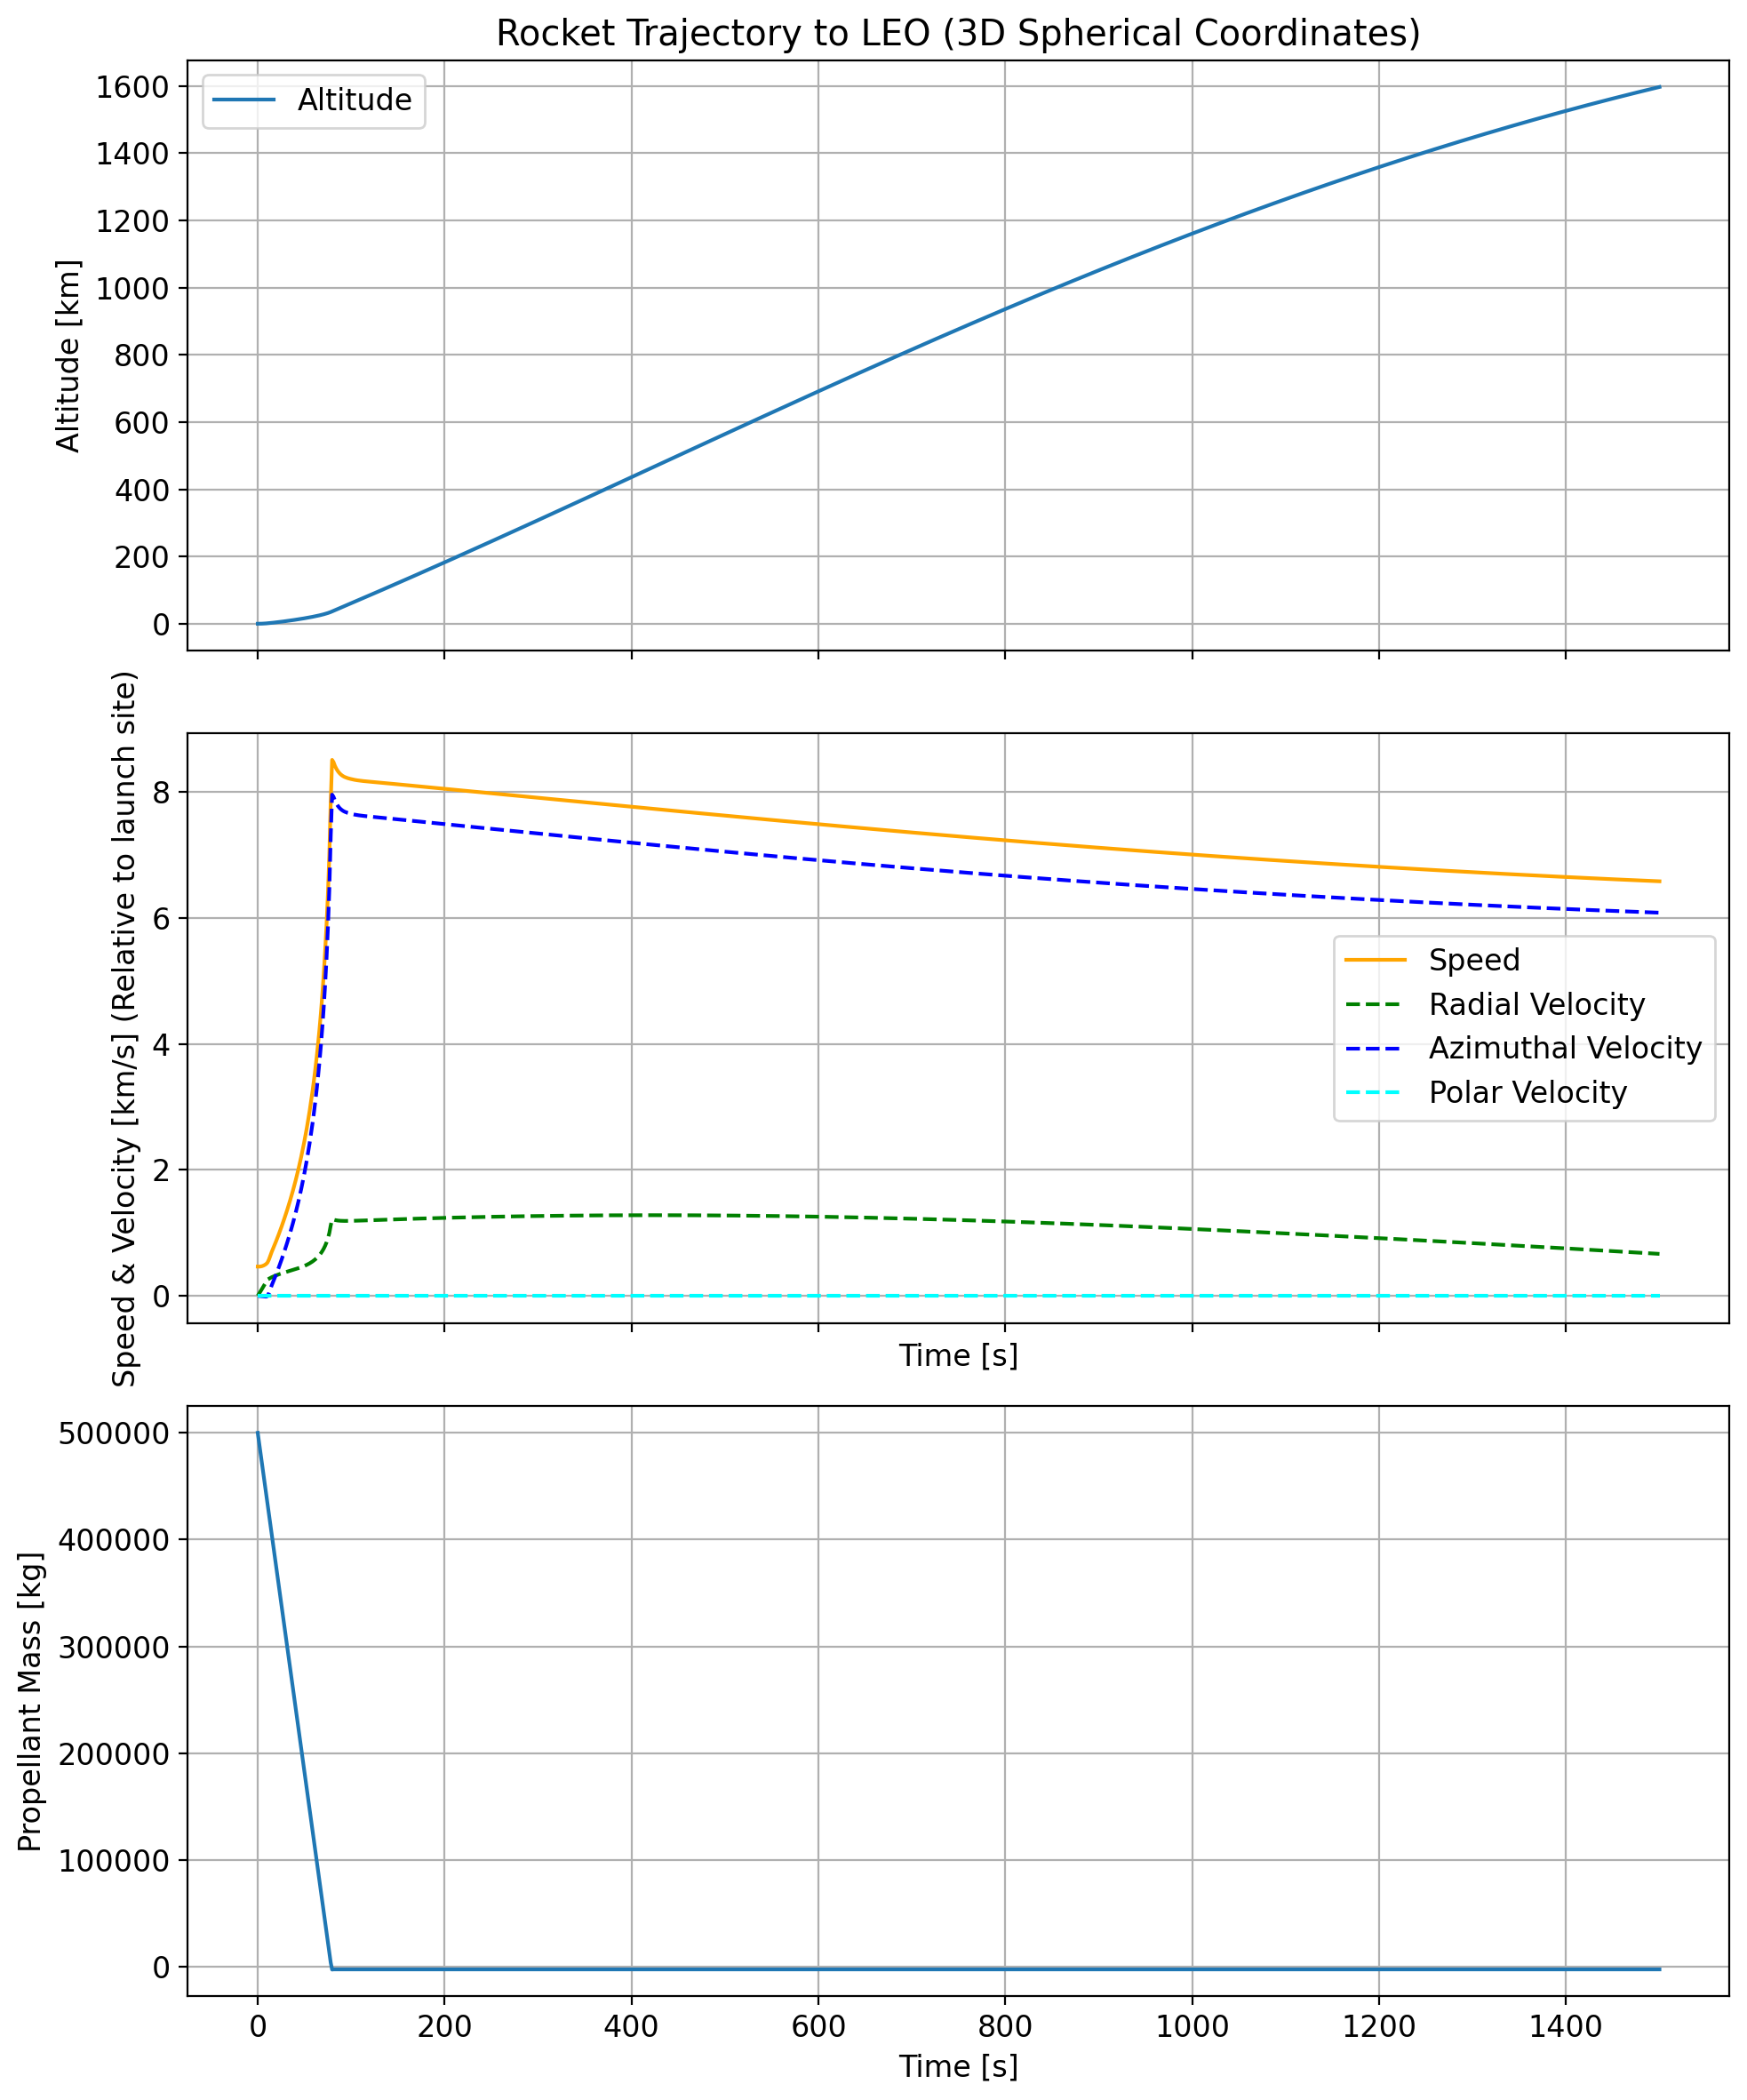

In [48]:
# 1. Define the rocket's physical parameters

# --- Rocket Parameters (Example: Falcon 9-like) ---
DRY_MASS = 25000  # kg (Mass of rocket without propellant)
PROPELLANT_MASS = 400000*1.25  # kg (Mass of propellant)
ROCKET_AREA = 10.8  # m^2 (Cross-sectional area for drag)
ROCKET_CD = 0.5  # (Simplified drag coefficient)
print(f'Propellant Mass Fraction = {PROPELLANT_MASS/(PROPELLANT_MASS+DRY_MASS)}')

falcon9_params = {
    'dry_mass': DRY_MASS,
    'propellant_mass': PROPELLANT_MASS,
    'area': ROCKET_AREA,
    'cd': ROCKET_CD
}

# 2. Define the propulsion system concept
merlin_engine_params = {
    'thrust_vac': (DRY_MASS+PROPELLANT_MASS)*9.8*3.75,
    'isp_vac': 310,
    'isp_sl': 280
}

# 3. Create and run the trajectory simulation (launching from the equator)
trajectory_sim = Trajectory(falcon9_params, merlin_engine_params)
solution = trajectory_sim.run_simulation(t_span=[0, 1500], launch_site_latitude=0)

# 4. Process and plot the results
t_eval = np.linspace(solution.t[0], solution.t[-1], 1000)
state_eval = solution.sol(t_eval)

r, theta, phi, vr, vtheta, vphi, mass = state_eval

# Calculate the thrust, drag & gravity forces through the flight
altitude_km = (r - trajectory_sim.R_EARTH) / 1000
speed_kps = np.sqrt(vr**2 + vtheta**2 + (vphi-vphi[0])**2) / 1000

# Short hand for the history data
history = trajectory_sim.history

# Plotting Altitude and Speed vs. Time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
ax1.plot(t_eval, altitude_km, label='Altitude')
ax1.set_ylabel('Altitude [km]')
ax1.grid(True)
ax1.legend()
ax1.set_title('Rocket Trajectory to LEO (3D Spherical Coordinates)')
ax2.plot(t_eval, speed_kps, label='Speed', color='orange')
ax2.plot(t_eval, vr/1000, label='Radial Velocity', color='green', linestyle="dashed")
ax2.plot(t_eval, (vtheta-vtheta[0])/1000, label='Azimuthal Velocity', color='blue', linestyle="dashed")
ax2.plot(t_eval, vphi/1000, label='Polar Velocity', color='cyan', linestyle="dashed")
ax2.set_ylabel('Speed & Velocity [km/s] (Relative to launch site)')
ax2.set_xlabel('Time [s]')
ax2.grid(True)
ax2.legend()
ax3.plot(t_eval, mass - DRY_MASS)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Propellant Mass [kg]')
ax3.grid(True)
plt.tight_layout()
plt.show()


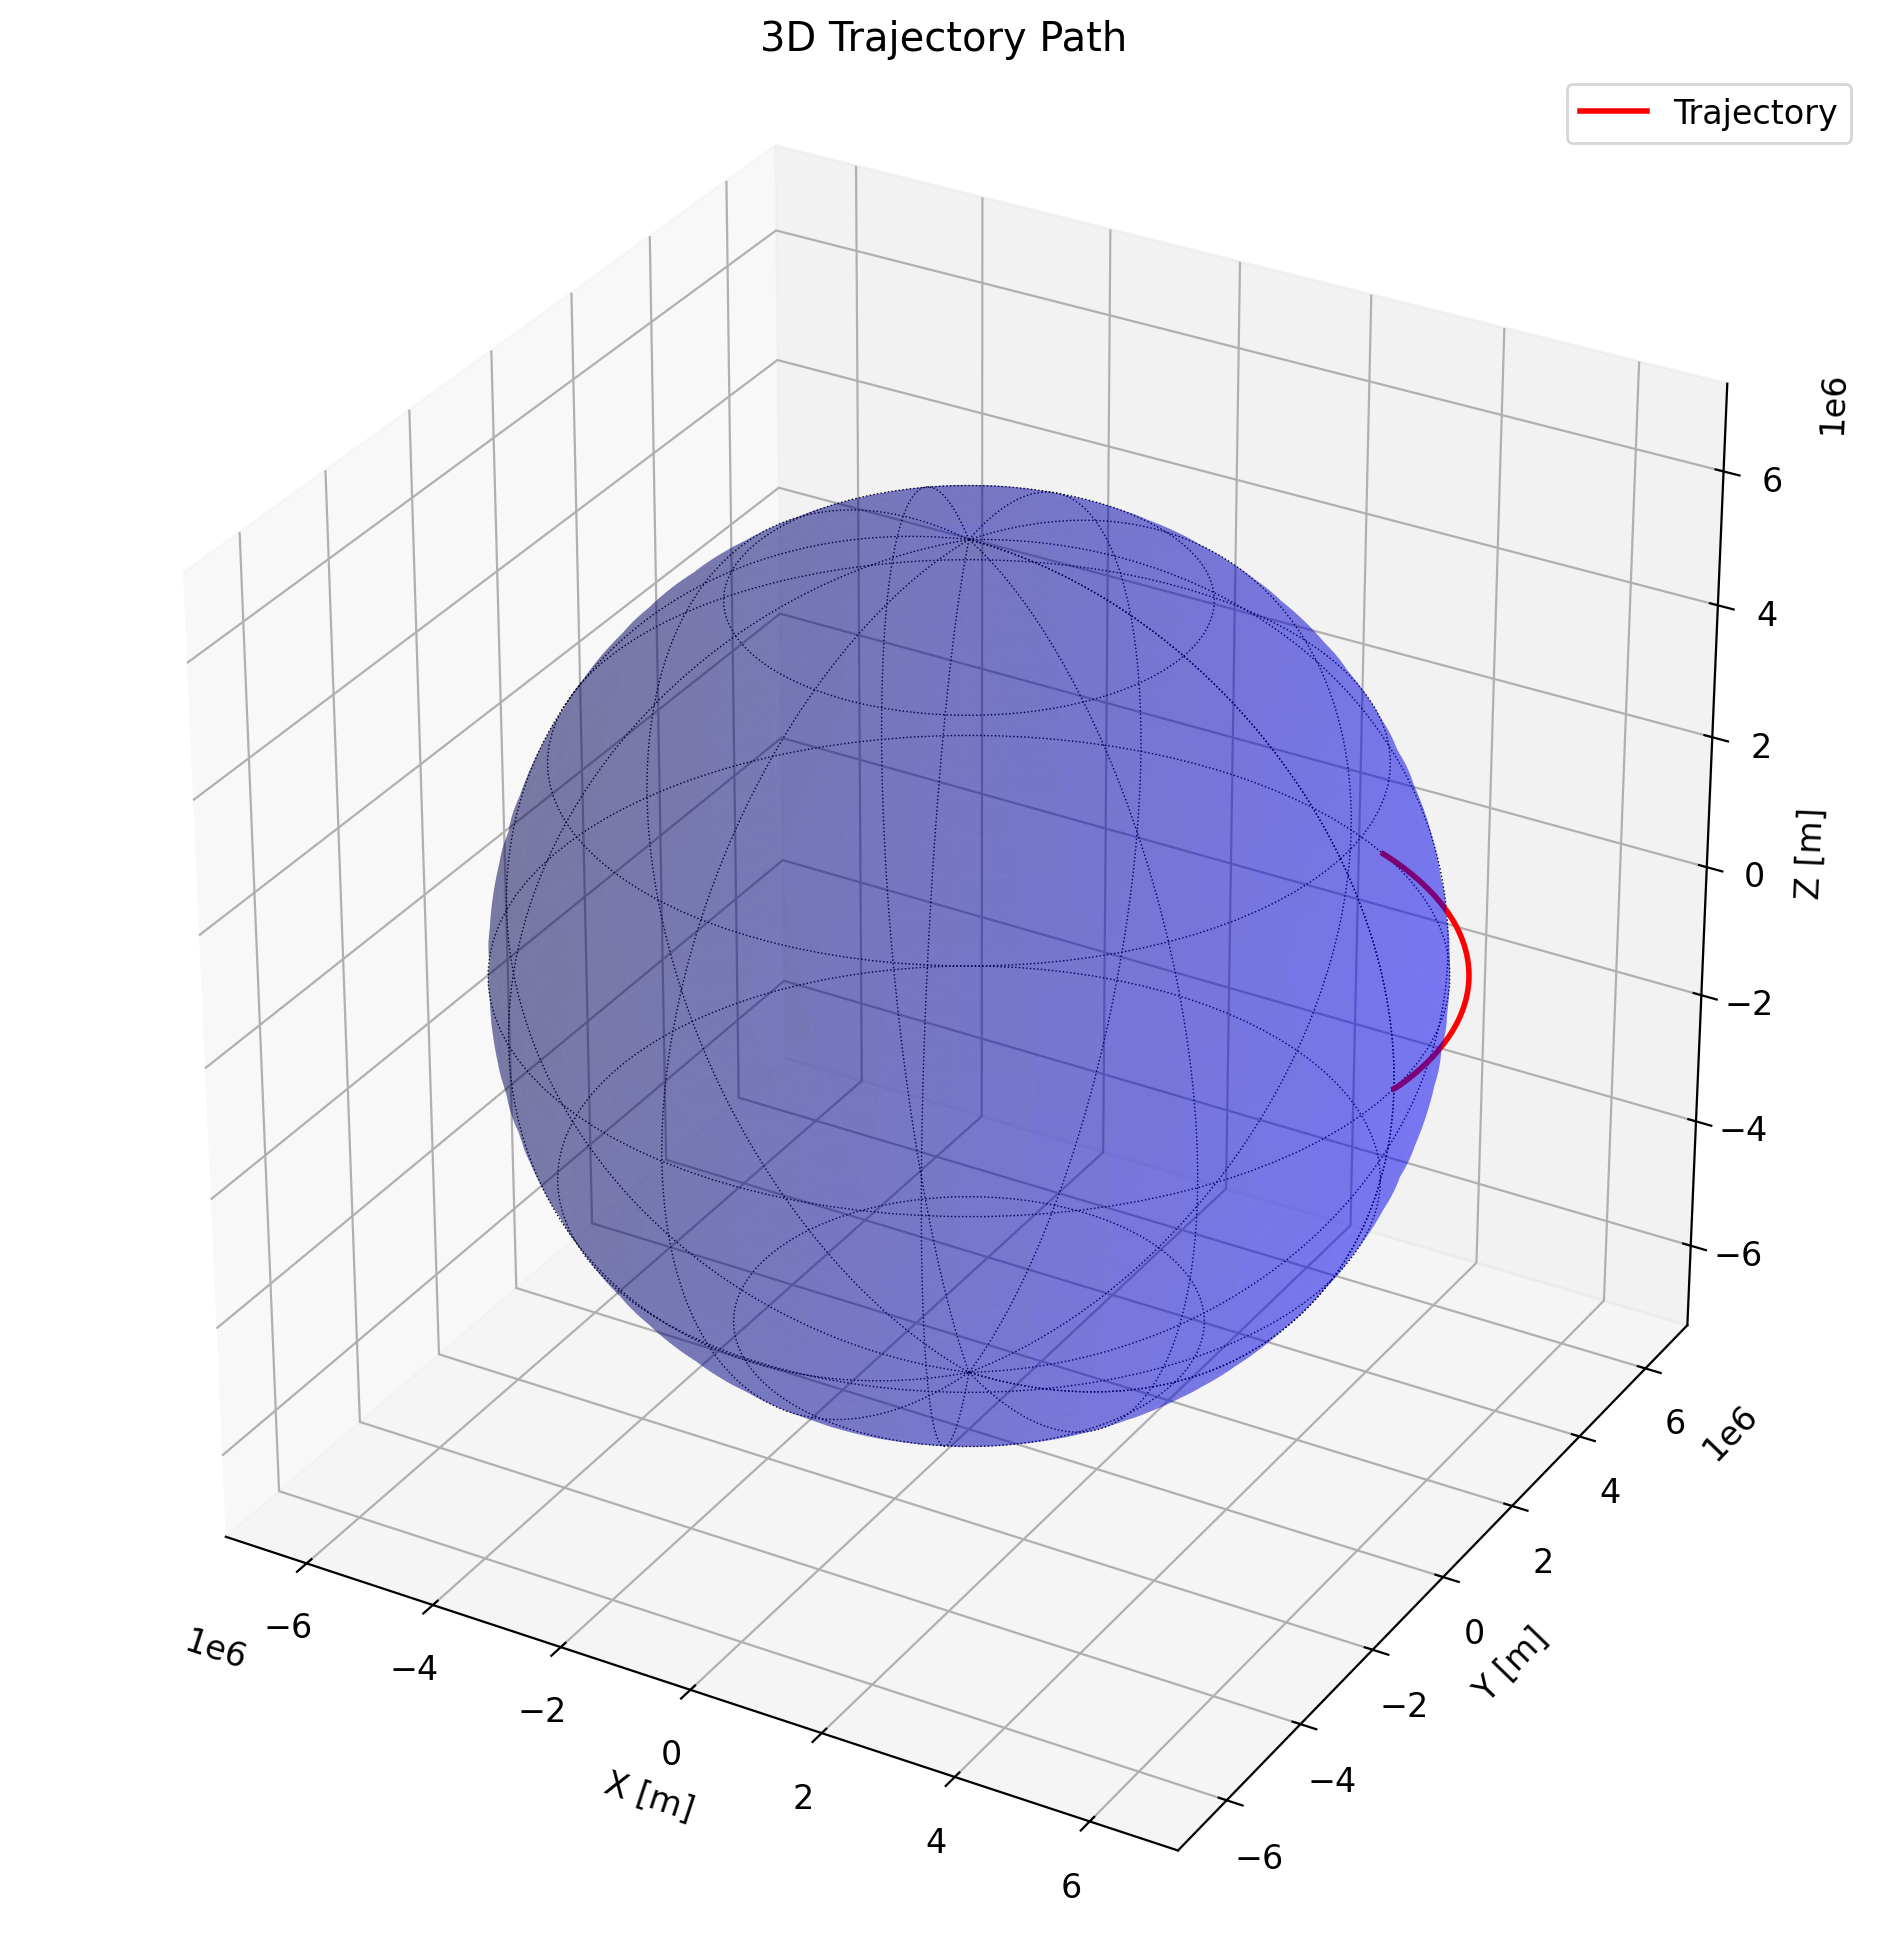

In [47]:
# Create the 3D figure
fig_3d = plt.figure(figsize=(12, 12))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# --- Draw the Textured Earth Sphere ---
# Create sphere grid
res = 200 # Resolution of the sphere
phi_sphere = np.linspace(0, 2 * np.pi, res)
theta_sphere = np.linspace(0, np.pi, res)
phi_sphere, theta_sphere = np.meshgrid(phi_sphere, theta_sphere)

# Convert to Cartesian coordinates
x_sphere = trajectory_sim.R_EARTH * np.sin(theta_sphere) * np.cos(phi_sphere)
y_sphere = trajectory_sim.R_EARTH * np.sin(theta_sphere) * np.sin(phi_sphere)
z_sphere = trajectory_sim.R_EARTH * np.cos(theta_sphere)

# Fallback to a solid color if texture fails
# Reduced alpha to make trajectory and grid lines visible
ax_3d.plot_surface(x_sphere, y_sphere, z_sphere, color='blue', alpha=0.3, rstride=5, cstride=5)

# --- Draw Latitude and Longitude Lines (Graticule) ---
graticule_color = 'black'
graticule_style = ':'
# Longitude lines (meridians)
for lon in np.linspace(0, 2 * np.pi, 12): # Every 30 degrees
  phi_line = np.linspace(0, np.pi, 100)
  # Increased radius slightly to plot lines above the Earth surface
  x_line = trajectory_sim.R_EARTH * np.sin(phi_line) * np.cos(lon)
  y_line = trajectory_sim.R_EARTH * np.sin(phi_line) * np.sin(lon)
  z_line = trajectory_sim.R_EARTH * np.cos(phi_line)
  ax_3d.plot(x_line, y_line, z_line, color=graticule_color, linestyle=graticule_style, linewidth=0.5)

# Latitude lines (parallels)
for lat in np.linspace(0, np.pi, 7)[1:-1]: # Every 30 degrees, excluding poles
  theta_line = np.linspace(0, 2 * np.pi, 100)
  # Increased radius slightly to plot lines above the Earth surface
  x_line = trajectory_sim.R_EARTH * np.sin(lat) * np.cos(theta_line)
  y_line = trajectory_sim.R_EARTH * np.sin(lat) * np.sin(theta_line)
  z_line = trajectory_sim.R_EARTH * np.cos(lat) * np.ones_like(theta_line)
  ax_3d.plot(x_line, y_line, z_line, color=graticule_color, linestyle=graticule_style, linewidth=0.5)

# --- Plot the Rocket's Trajectory ---
# Convert trajectory from spherical to Cartesian for plotting
x_path = r * np.sin(phi) * np.cos(theta)
y_path = r * np.sin(phi) * np.sin(theta)
z_path = r * np.cos(phi)
ax_3d.plot(x_path, y_path, z_path, color='red', label='Trajectory', linewidth=2)

# --- Final Plot Adjustments ---
max_range = np.max(r) * 1.1
ax_3d.set_xlim([-max_range, max_range])
ax_3d.set_ylim([-max_range, max_range])
ax_3d.set_zlim([-max_range, max_range])
ax_3d.set_xlabel('X [m]')
ax_3d.set_ylabel('Y [m]')
ax_3d.set_zlabel('Z [m]')
ax_3d.set_title('3D Trajectory Path')
ax_3d.legend()

# Set aspect ratio to be equal
ax_3d.set_box_aspect([1,1,1])

plt.show()